In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Загрузка данных
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_dataset

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 39205946.98it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 2450601.72it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2676310.49it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1007271.65it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [ ]:
# загрузка даннх
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
import numpy as np

train_labels = np.array(train_dataset.targets)
test_labels = np.array(test_dataset.targets)

train_class_counts = np.bincount(train_labels)
test_class_counts = np.bincount(test_labels)

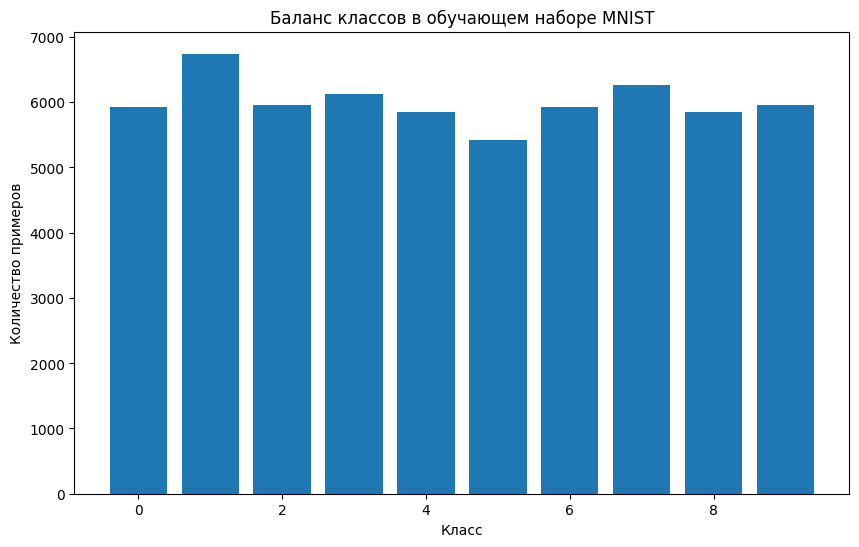

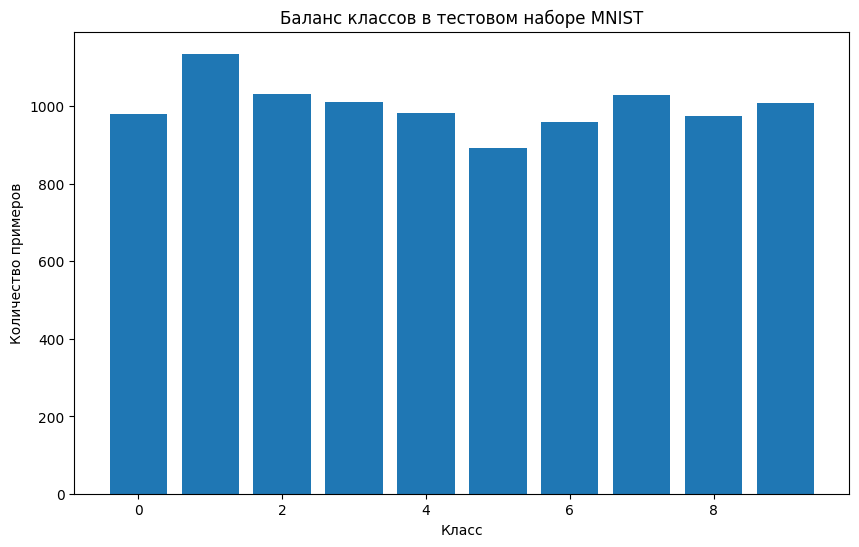

In [ ]:
# баланс классов
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(10), train_class_counts)
ax.set_xlabel('Класс')
ax.set_ylabel('Количество примеров')
ax.set_title('Баланс классов в обучающем наборе MNIST')
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(10), test_class_counts)
ax.set_xlabel('Класс')
ax.set_ylabel('Количество примеров')
ax.set_title('Баланс классов в тестовом наборе MNIST')
plt.show()

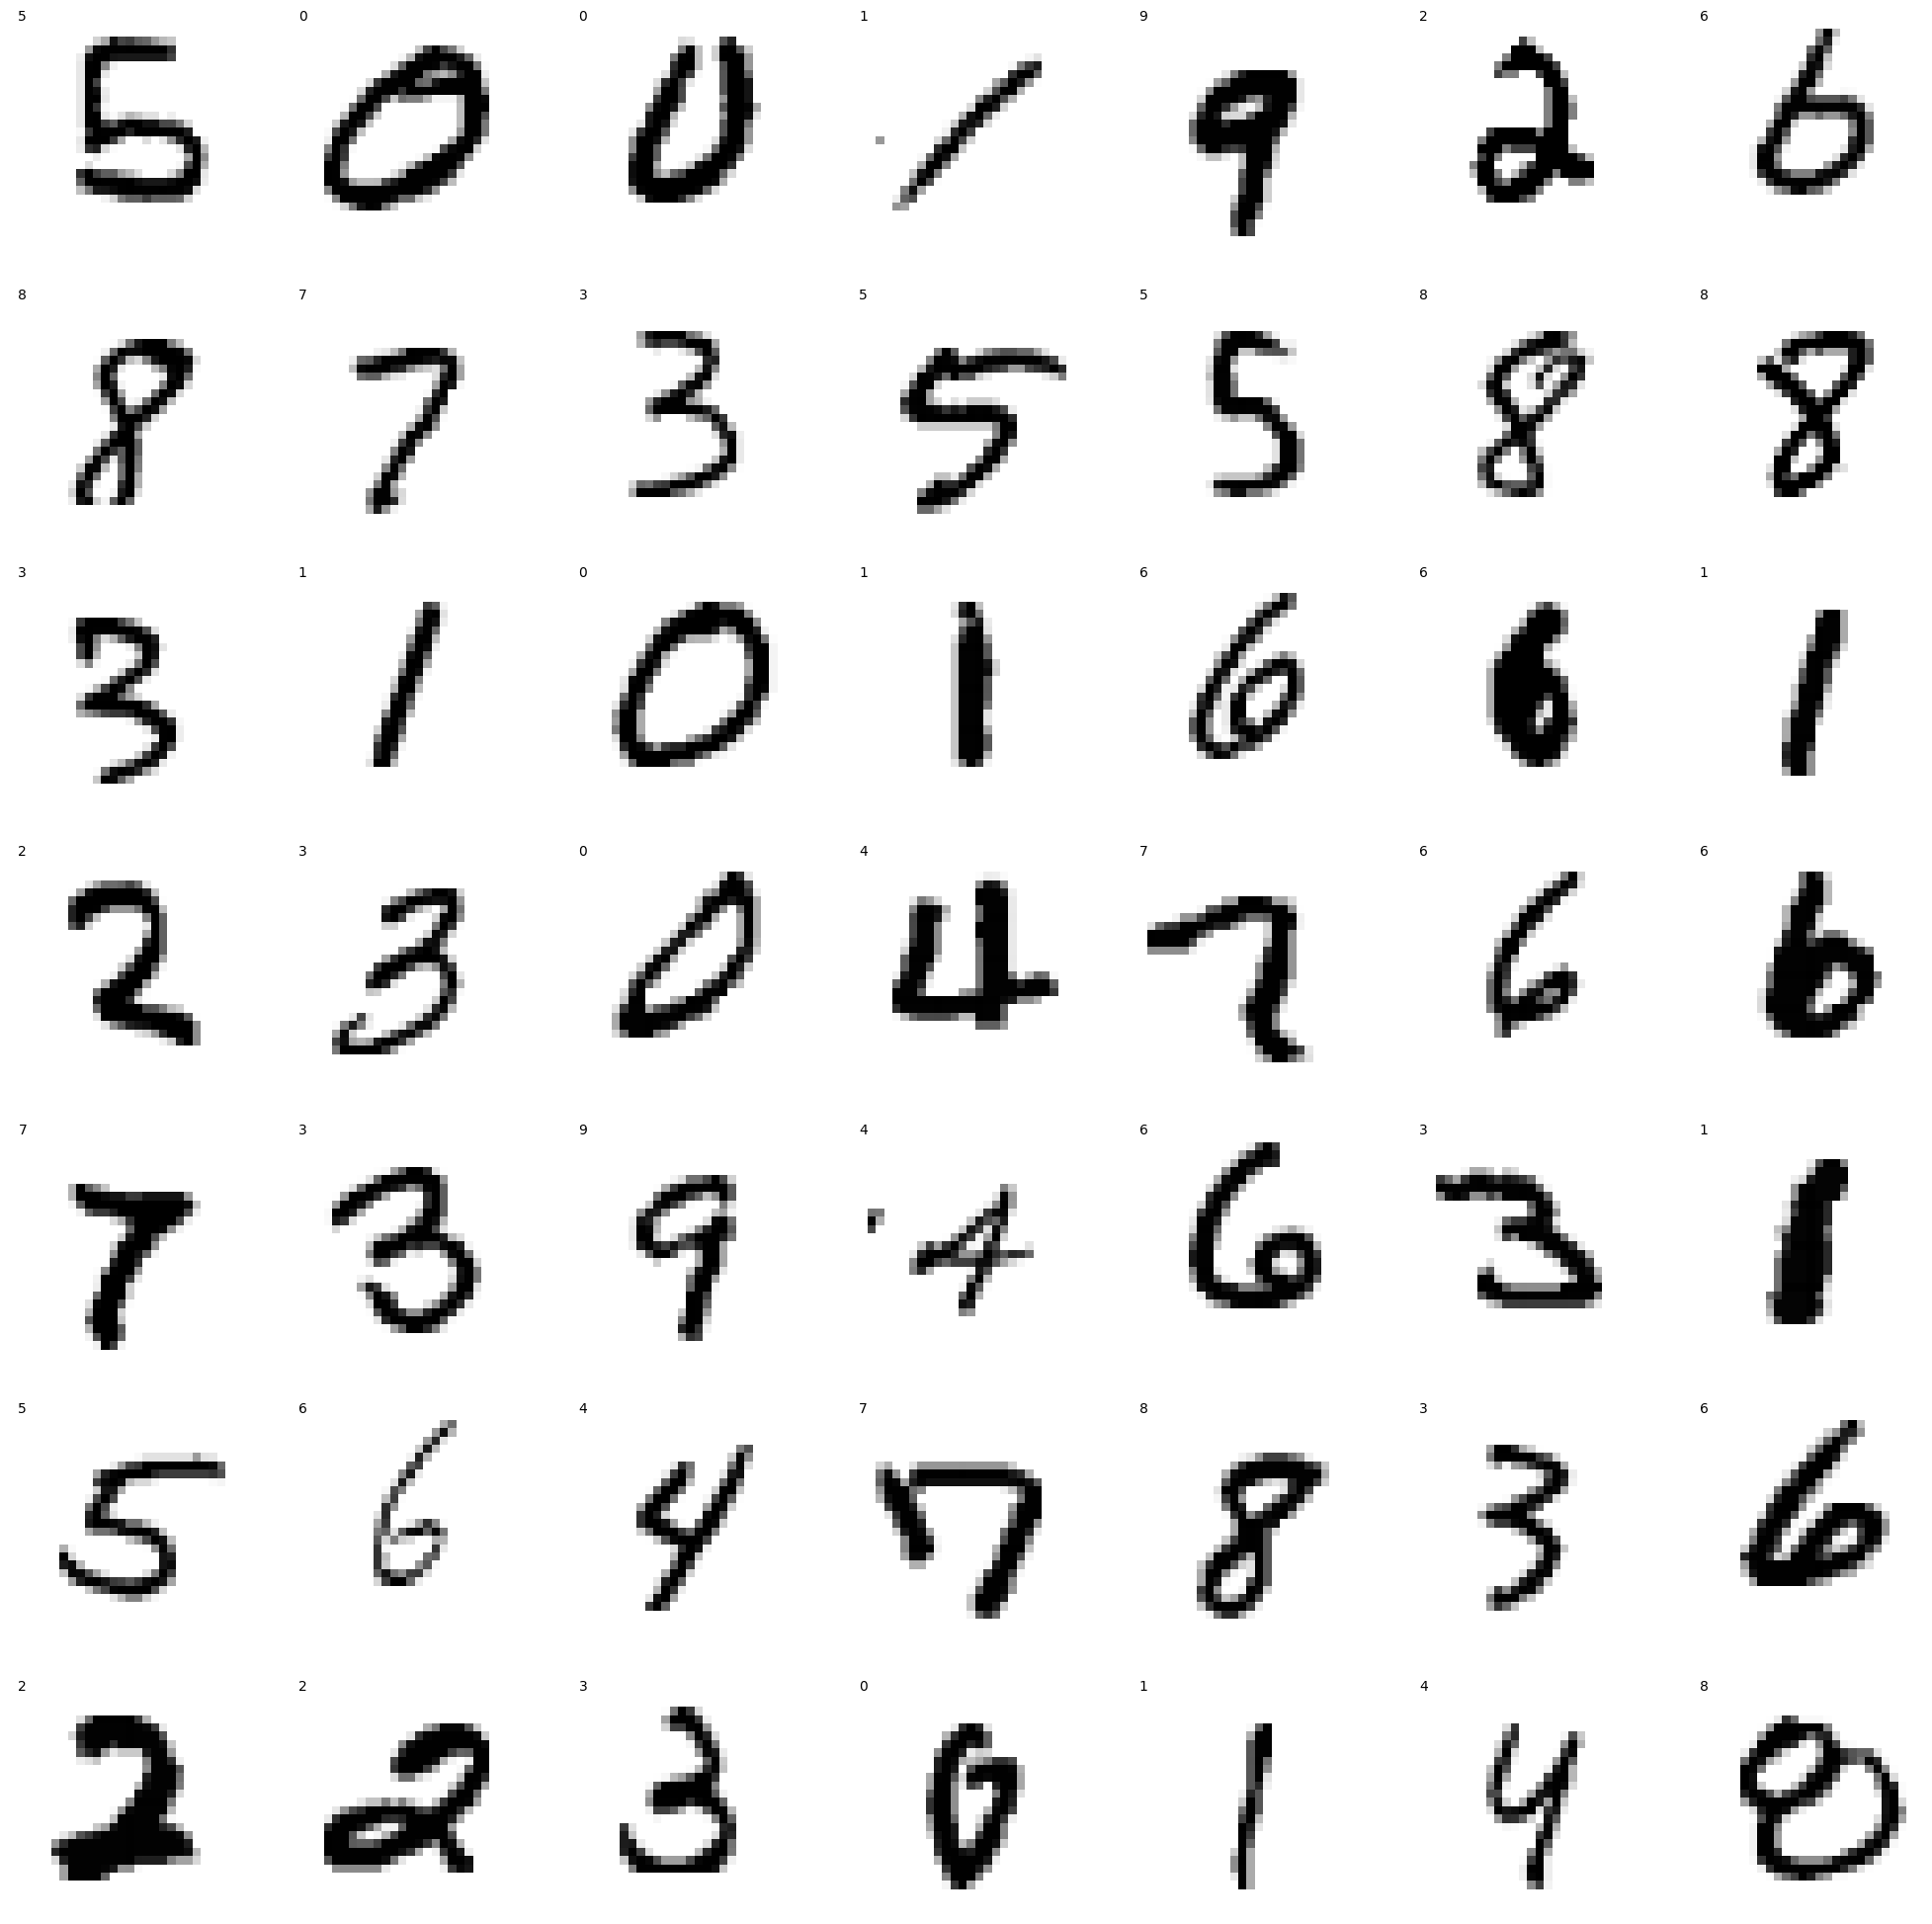

In [ ]:
# визуализация обучающей выборки
dataiter = iter(train_loader)
images, labels = next(dataiter)

fig, axs = plt.subplots(7, 7, figsize=(25,25))
for i, ax in enumerate(axs.flatten()):
    ax.text(0.5,0.5,labels[i].item())
    ax.imshow(images[i].numpy().squeeze(), cmap='gray_r')
    ax.axis('off')

In [ ]:
print(f"Кол-во изображений train: {len(train_dataset)}")
print(f"Кол-во изображений test: {len(test_dataset)}")
print(f"Минимальное значение пикселя: {train_dataset[0][0].min()}")
print(f"Максимальное значение пикселя: {train_dataset[0][0].max()}")

Кол-во изображений train: 60000
Кол-во изображений test: 10000
Минимальное значение пикселя: -1.0
Максимальное значение пикселя: 1.0


In [ ]:
# создаю новый датасет, где будут использоваться только белые и черные пиксели
# потом буду сравнивать точности двух моделей
# первая модель будет обучена на MNIST, вторая - на бинаризованных изображениях
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor


def binarize_image(image, threshold=0.5):
    image[image >= threshold] = 1.0
    image[image < threshold] = 0.0
    return image

# Определение нового датасета с бинаризованными изображениями
class BinarizedMNIST(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.mnist_dataset = torchvision.datasets.MNIST(root=root, train=train, download=True, transform=transform)

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, index):
        image, label = self.mnist_dataset[index]
        binarized_image = binarize_image(image)
        return binarized_image, label

# Загрузка бинаризованного датасета
train_data = BinarizedMNIST(root='data/', train=True, transform=ToTensor())
test_data = BinarizedMNIST(root='data/', train=False, transform=ToTensor())

# Создание загрузчиков данных
train_loader_new = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader_new = DataLoader(test_data, batch_size=64, shuffle=False)

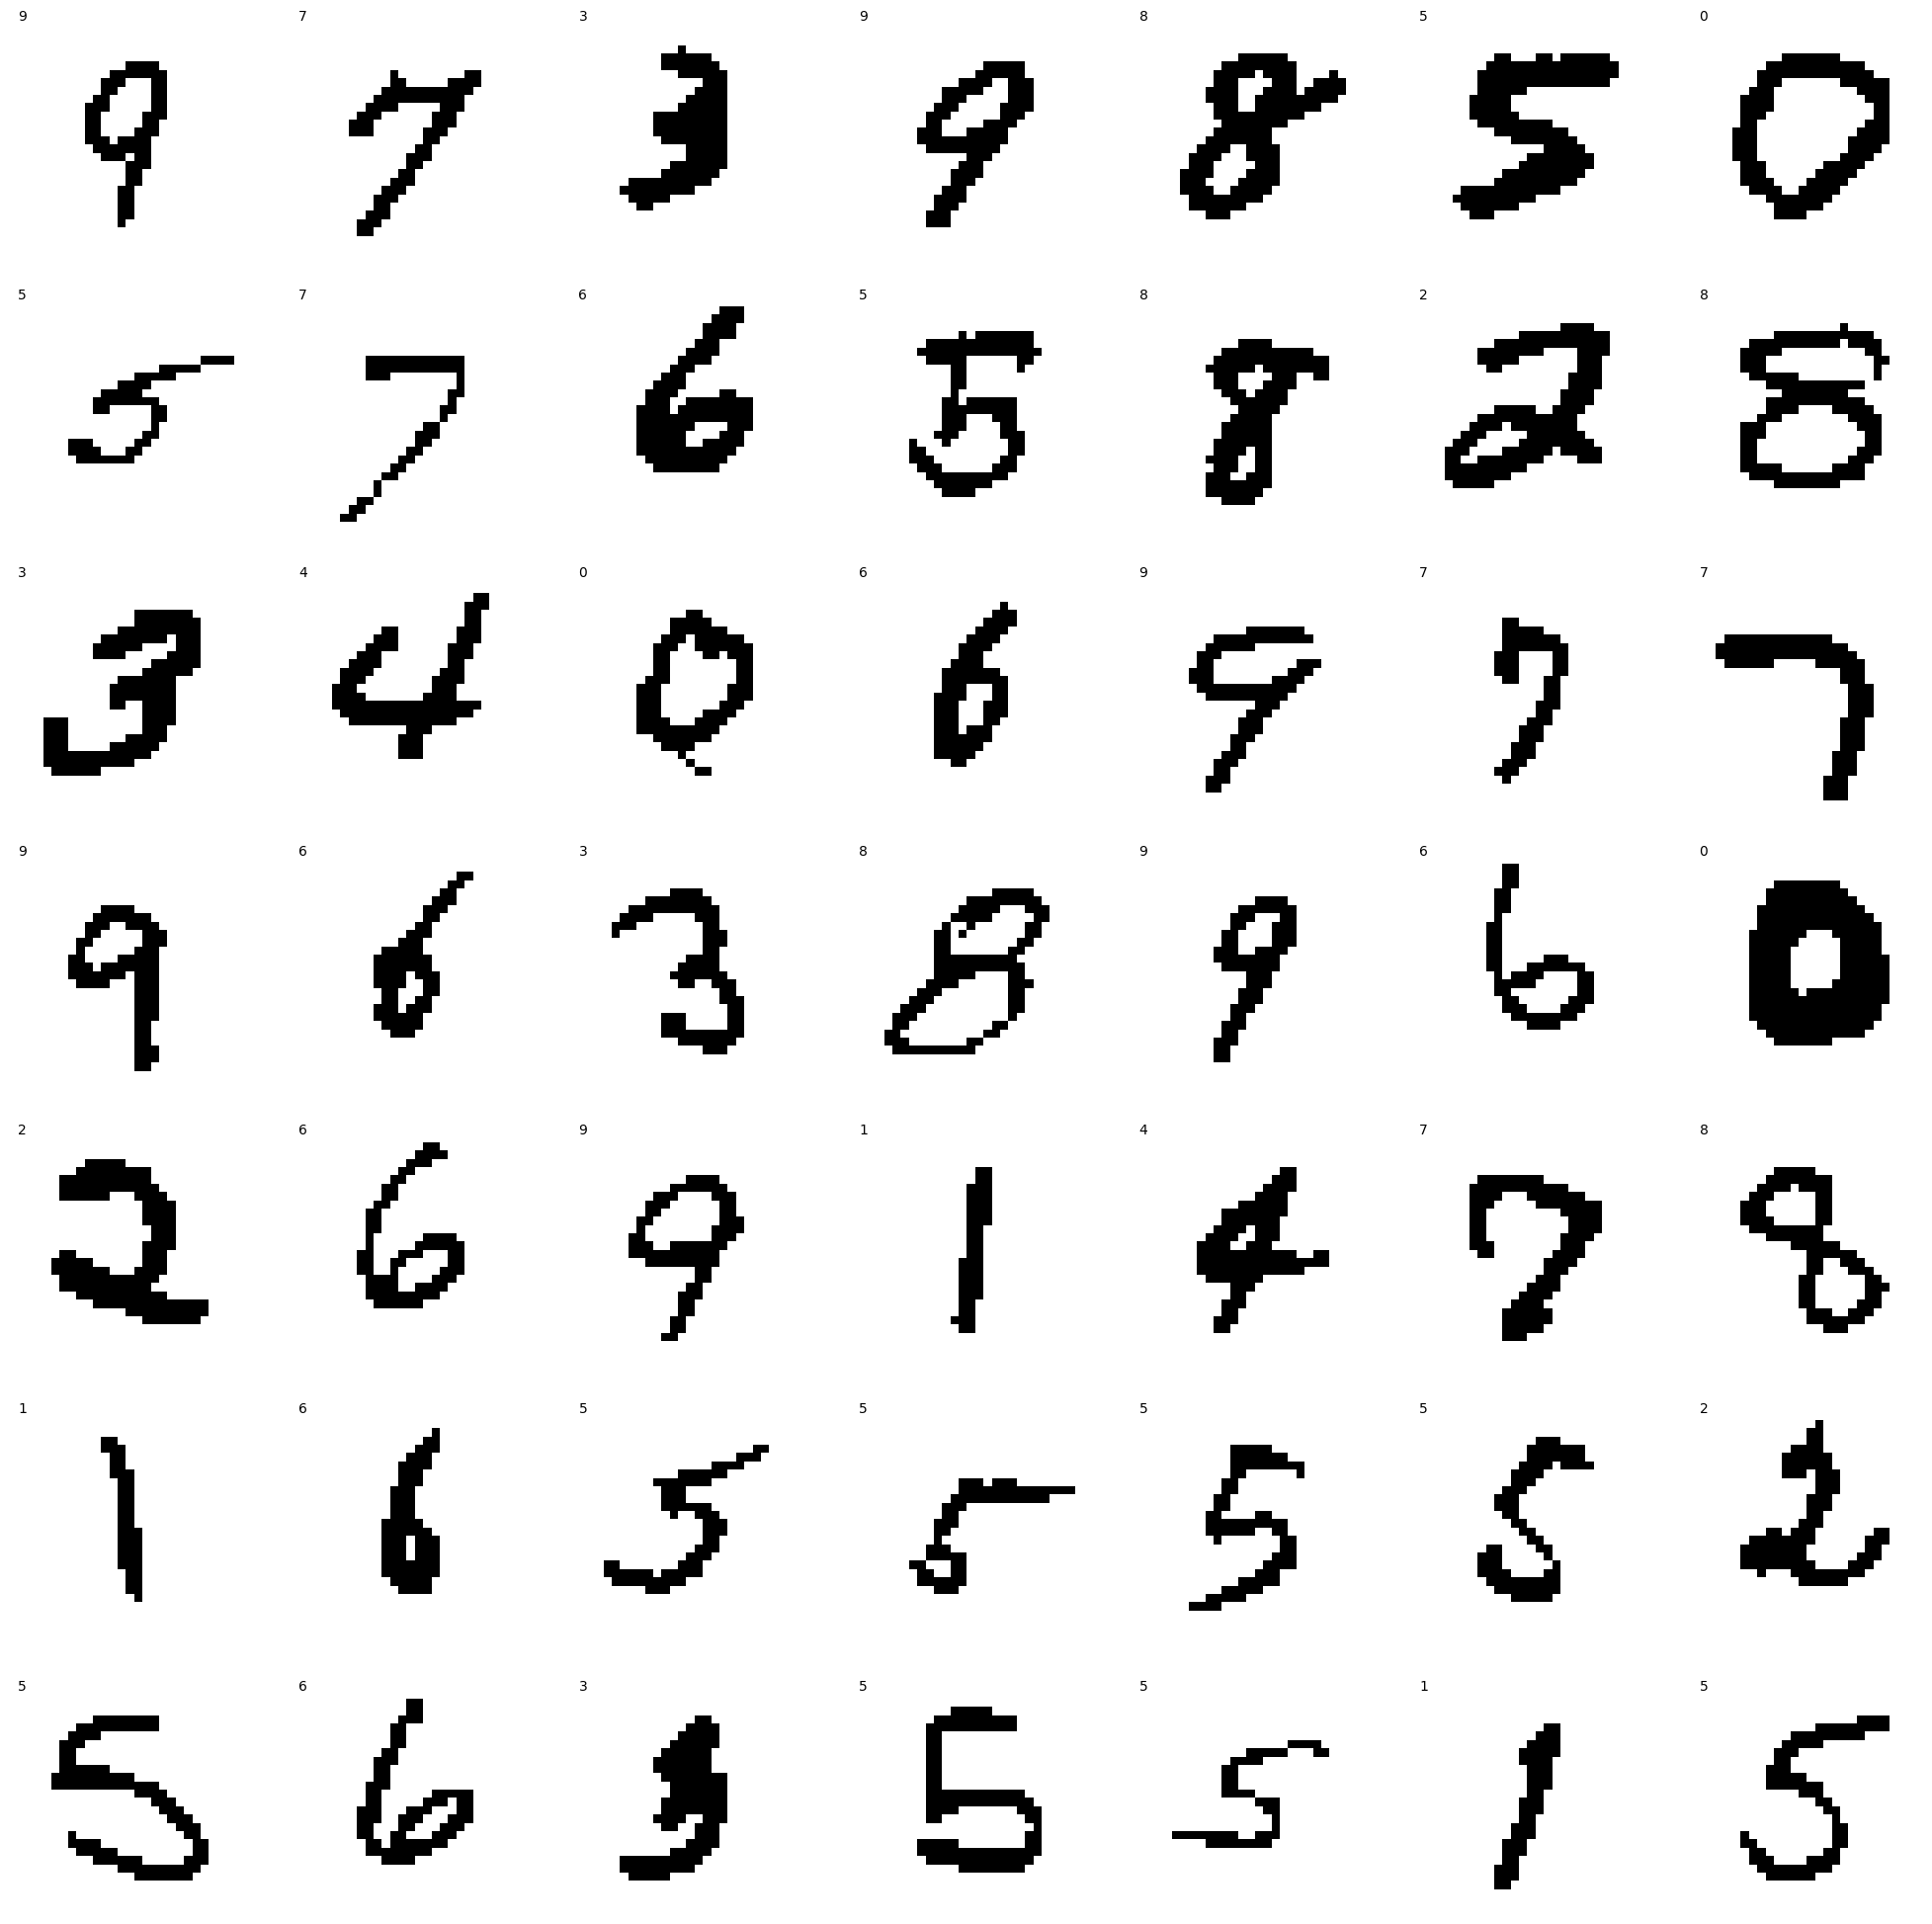

In [ ]:
# визуализация бинаризованной обучающей выборки
dataiter = iter(train_loader_new)
images, labels = next(dataiter)

fig, axs = plt.subplots(7, 7, figsize=(25,25))
for i, ax in enumerate(axs.flatten()):
    ax.text(0.5,0.5,labels[i].item())
    ax.imshow(images[i].numpy().squeeze(), cmap='gray_r')
    ax.axis('off')

In [ ]:
# класс нейронной сети
# во входном слое будет 784 нейрона - для каждого пикселя
# в выходном - 10 - для каждого класса
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(28 * 28, 128)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(128, 64)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(64, 10)
        self.act3 = nn.LogSoftmax(dim=1)


    def forward(self, x):
        x = x.view(-1, 28 * 28)

        x = self.fc1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.act3(x)
        return x

In [ ]:
import tqdm
from tqdm.auto import tqdm

def train_stochastic(model, loader, criterion, optimizer, num_epoch):
    for epoch in tqdm(range(num_epoch)):
        epoch_loss = []

        for X_batch, y_batch in loader:
            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch)
            epoch_loss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}, Loss: {np.mean(epoch_loss)}')

    return model

In [ ]:
# первая модель будет обучаться на небинаризованном датасете
model = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# обучение первой модели
train_stochastic(model, train_loader, criterion, optimizer, num_epoch=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Loss: 0.40274320988417434
Epoch 2, Loss: 0.19344774573278833
Epoch 3, Loss: 0.14125350408001877
Epoch 4, Loss: 0.11126262854053967
Epoch 5, Loss: 0.09579064942268865
Epoch 6, Loss: 0.08220408096520314
Epoch 7, Loss: 0.07314314346076416
Epoch 8, Loss: 0.06478697475520516
Epoch 9, Loss: 0.058709604107389554
Epoch 10, Loss: 0.05634467103960378
Epoch 11, Loss: 0.04723732261697569
Epoch 12, Loss: 0.0487058165348269
Epoch 13, Loss: 0.04625743084755574
Epoch 14, Loss: 0.040194702349160845
Epoch 15, Loss: 0.03971657697602224
Epoch 16, Loss: 0.033203636352160226
Epoch 17, Loss: 0.03303871084115595
Epoch 18, Loss: 0.0337069977443872
Epoch 19, Loss: 0.03193446952990926
Epoch 20, Loss: 0.027678119177302184
Epoch 21, Loss: 0.028386258115160226
Epoch 22, Loss: 0.02643493506695492
Epoch 23, Loss: 0.025384349911165744
Epoch 24, Loss: 0.0229907384281857
Epoch 25, Loss: 0.024665223677458773
Epoch 26, Loss: 0.018721247374686965
Epoch 27, Loss: 0.02625798235518864
Epoch 28, Loss: 0.01915374795945

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (act3): LogSoftmax(dim=1)
)

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total}%')

Test Accuracy: 97.61%


In [ ]:
# вторая модель будет обучаться на бинаризованном датасете
model2 = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)

In [ ]:
train_stochastic(model2, train_loader_new, criterion, optimizer, num_epoch=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Loss: 0.35694952920349293
Epoch 2, Loss: 0.1497950410581569
Epoch 3, Loss: 0.09931498010759987
Epoch 4, Loss: 0.07489808471942905
Epoch 5, Loss: 0.053367919906520095
Epoch 6, Loss: 0.04286528995273255
Epoch 7, Loss: 0.031491082980916074
Epoch 8, Loss: 0.023997615956069494
Epoch 9, Loss: 0.021295715338994325
Epoch 10, Loss: 0.016889478799348115
Epoch 11, Loss: 0.013368706554073273
Epoch 12, Loss: 0.012040679375980488
Epoch 13, Loss: 0.010234016089020722
Epoch 14, Loss: 0.011370721392364985
Epoch 15, Loss: 0.008048576260818997
Epoch 16, Loss: 0.011252727597704569
Epoch 17, Loss: 0.0055221393640618845
Epoch 18, Loss: 0.011200026535981688
Epoch 19, Loss: 0.007495458518404
Epoch 20, Loss: 0.006655282681671629
Epoch 21, Loss: 0.00829837747443995
Epoch 22, Loss: 0.003854921436989082
Epoch 23, Loss: 0.006034837207921449
Epoch 24, Loss: 0.009030469248614403
Epoch 25, Loss: 0.008017435436565115
Epoch 26, Loss: 0.004060564615984859
Epoch 27, Loss: 0.00780553439147819
Epoch 28, Loss: 0.00

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (act3): LogSoftmax(dim=1)
)

In [ ]:
model2.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader_new:
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total}%')

Test Accuracy: 97.11%


В итоге, в ходе работы были обучены 2 модели: 1ая - на датасете MNIST, 2ая - на бинаризованном датасете MNIST. Были выведены тренировочные выборки этих датасетов и баланс классов. Точность 1ой модели составила 0.9761, когда точность 2ой модели составила 0.9711.